<a href="https://colab.research.google.com/github/JoaoGranja/Indoor_object_detection/blob/master/yolov7_indoor_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor Object Detection

In this project, I loaded the Indoor Object Detection dataset (https://zenodo.org/record/2654485#.YaYShVPMJhE) and train a custom YOLOv7 model to recognize the objects in our dataset. To do so I will take the following steps::

1.   **Setup Code**
2.   **Data Preprocessing**
  
  a Convert the Annotations into the YOLO v7 Format 
  
  b) Testing the annotations
3.   **Partition the Dataset**
4.   **Training Yolo v7 model**
5.   **Show training/validation results**
6.   **Testing**
7.   **Future Work**




# Step 1: Setup Code

In [1]:
# Package Installation and share Google Drive    
!pip install --upgrade pip


from google.colab import drive    
drive.mount('/content/drive', force_remount=True)

import os, sys
sys.path.append('/content/drive/MyDrive/colab/DocuSketch')
os.chdir('/content/drive/MyDrive/colab/DocuSketch')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Mounted at /content/drive


In [2]:
# Clone GitHub repository, install dependencies and check PyTorch and GPU.
if not os.path.isdir('yolov7'):
    #Import yolov7 model
    !git clone https://github.com/WongKinYiu/yolov7

%cd yolov7
%pip install -qr requirements.txt  # install

import torch
import utils

Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.93 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (522/522), done.
Updating files: 100% (104/104), done.
/content/drive/MyDrive/colab/DocuSketch/yolov7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Step 2: Data Preprocessing

In [4]:
os.chdir('/content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset')

if os.path.isdir('images'):  
  shutil.rmtree('images')
if os.path.isdir('annotations'): 
  shutil.rmtree('annotations')
if os.path.isdir('labels'): 
  shutil.rmtree('labels')

!mkdir images
!mkdir labels
!mkdir annotations

## a) Convert the Annotations into the YOLO v7 Format

In [5]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info_list 
    info_list = []
    
    # Parse the XML Tree
    for image in root.iter('image'):
        image_dict = {}
        image_dict['bboxes'] = []
        # Get the file name 
        if 'file' in image.attrib:
            image_dict['filename'] = image.attrib['file']

        for box in image.iter('box'):
            # Get details of the bounding box 
            bbox = box.attrib

            for label in box:
                if label.tag == "label":
                    bbox["class"] = label.text
                            
            image_dict['bboxes'].append(bbox)
        
        info_list.append(image_dict)
    
    return info_list

In [6]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"fireextinguisher": 0,
                            "chair": 1,
                            "exit": 2,
                            "clock": 3,
                            "trashbin": 4,
                            "screen": 5,
                            "printer": 6}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov7(info_list):
    image_w, image_h = 1280,720
    
    # For each bounding box
    for info in info_list:
        print_buffer = []
        for b in info["bboxes"]:
            try:
                class_id = class_name_to_id_mapping[b["class"]]
            except KeyError:
                print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            
            # Transform the bbox co-ordinates as per the format required by YOLO v7
            b_center_x = int(b["left"]) + (int(b["width"]) / 2)
            b_center_y = int(b["top"]) + (int(b["height"]) / 2)
            b_width    = int(b['width'])
            b_height   = int(b['height'])
            
            # Normalise the co-ordinates by the dimensions of the image
            b_center_x /= image_w 
            b_center_y /= image_h 
            b_width    /= image_w 
            b_height   /= image_h 
            
            #Write the bbox details to the file 
            print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
            
        # Name of the file which we have to save 
        save_file_name = os.path.join("annotations", info["filename"].replace("jpg", "txt"))
        
        # Save the annotation to disk
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [7]:
# Get the annotations
annotations = [os.path.join('annotation', x) for x in os.listdir('annotation') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov7(info_dict)

annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


In [8]:
# Get the images
sequence_list = [x for x in os.listdir('.') if 'sequence' in x]

for sequence in tqdm(sequence_list):
    try:
        shutil.copytree(sequence, 'images', dirs_exist_ok=True)
    except:
        print(sequence)
        assert False


100%|██████████| 6/6 [00:40<00:00,  6.78s/it]


## b) Testing the annotations

Label = exit


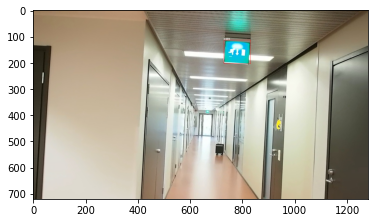

In [9]:
# random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_file):
  with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline='red')
        
        print(f"Label = {class_id_to_name_mapping[(int(obj_cls))]}")
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)

# Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
# print(image_file, annotation_file)
assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, annotation_file)

# Step 3: Partition the Dataset

In [10]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [11]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [12]:
# Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

# Step 4: Training Yolo v7 model

For this case we use the following hyper parameters:

- **img:** 640
- **batch:** 32
- **epochs:** 50
- **model architecture:** yolov7s
- **yperparameter config file:** hyp.scratch-low.yaml
- **data config:** custom indoor.yaml created below
- **weights:** yolov7s.pt
- **train name:** indoor_yolo
- **cache:** cache images for faster training

In [13]:
os.chdir('/content/drive/MyDrive/colab/DocuSketch/yolov7')

In [14]:
text = """train: ../Indoor Object Detection Dataset/images/train/ 
val:  ../Indoor Object Detection Dataset/images/val/
test: ../Indoor Object Detection Dataset/images/test/

# number of classes
nc: 7

# class names
names: ["fireextinguisher", "chair", "exit", "clock", "trashbin", "screen", "printer"]"""
with open('data/indoor.yaml', 'w') as f:
  f.write(text)

In [17]:
!python train.py --img-size 640 --cfg cfg/training/yolov7-tiny.yaml --hyp data/hyp.scratch.tiny.yaml --batch 32 --epochs 30 --data data/indoor.yaml --weights yolov7-tiny.pt --workers 24 --name indoor_yolo --cache

YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=True, cfg='cfg/training/yolov7-tiny.yaml', data='data/indoor.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.tiny.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='indoor_yolo', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/indoor_yolo2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, v5_metric=False, weights='yolov7-tiny.pt', workers=24, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, wa

## Show training/validation results

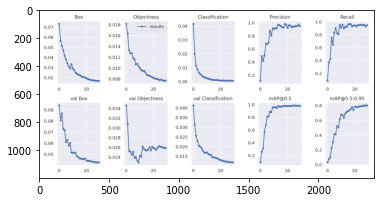

In [21]:
results = Image.open('runs/train/indoor_yolo/results.png')
plt.imshow(np.array(results))

# Step 5: Inference
Run inference with the best trained weights over testing dataset


In [22]:
!python detect.py --source '../Indoor Object Detection Dataset/images/test/' --weights runs/train/indoor_yolo/weights/best.pt --conf 0.25 --name indoor_yolo_det

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='indoor_yolo_det', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='../Indoor Object Detection Dataset/images/test/', update=False, view_img=False, weights=['runs/train/indoor_yolo/weights/best.pt'])
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Fusing layers... 
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6023832 parameters, 0 gradients, 13.1 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

3 chairs, Done. (7.2ms) Inference, (1.5ms

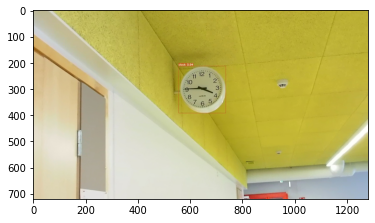

In [23]:
# Show example of a detection image
detections_dir = "runs/detect/indoor_yolo_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# Step 6: Testing
Testing best trained model over testing dataset. 
We will get mAP50 for all classes and showing testing results as well as some good and bad examples (comparing original images+annotations and corresponding detection images)

In [24]:
!python test.py --weights runs/train/indoor_yolo/weights/best.pt --data indoor.yaml --task test --name yolo_det

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/indoor.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='yolo_det', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', v5_metric=False, verbose=False, weights=['runs/train/indoor_yolo/weights/best.pt'])
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Fusing layers... 
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6023832 parameters, 0 gradients, 13.1 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

test: Scanning '../Indoor Object Detection D

### Show some testing results

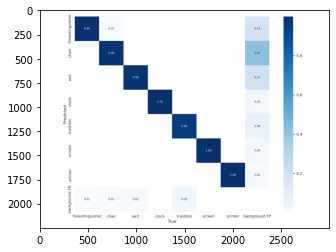

In [25]:
# Confusion Matrix
plt.imshow(np.array(Image.open("runs/test/yolo_det/confusion_matrix.png")))

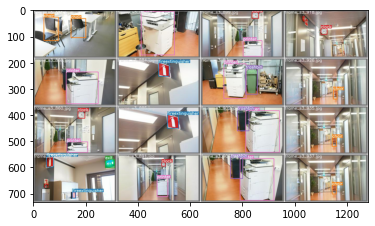

In [26]:
# Original images with labels for batch 0
plt.imshow(np.array(Image.open("runs/test/yolo_det/test_batch0_labels.jpg")))

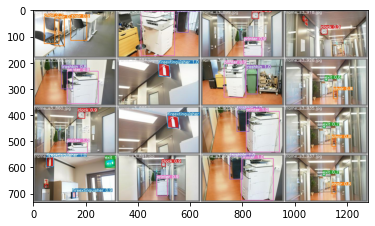

In [27]:
# Prediction images for batch 0
plt.imshow(np.array(Image.open("runs/test/yolo_det/test_batch0_pred.jpg")))

## Good example
To choose a good example I compared the previous two images and pick the image name where the bouxing boxes and class match.

Label = clock
Label = printer


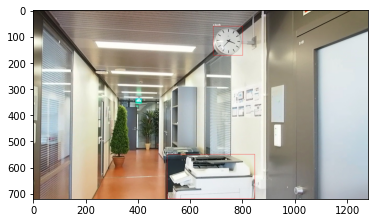

In [28]:
# Original image
image_name = 'frame_s3_860.jpg'
image_file = os.path.join('/content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset/images/test', image_name)

# Get the corresponding label file
label_file = image_file.replace("images", "labels").replace("jpg", "txt")

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, label_file)

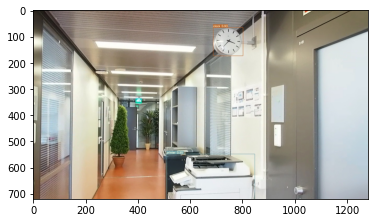

In [29]:
# Prediction
prediction_image_path = os.path.join('runs/detect/indoor_yolo_det/', image_name)
prediction_image = Image.open(prediction_image_path)
plt.imshow(np.array(prediction_image))

Comparing the 2 previous images we can verify that the Yolo v7 model detects both clock and printer with high confidence.

## Bad Example
To choose a bad example I compared the previous images and pick the image name where the bouxing boxes and class didn't match.

Label = printer


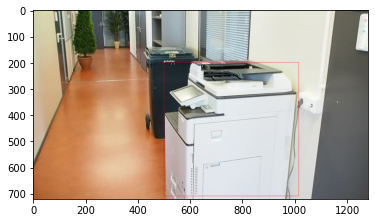

In [30]:
# Original image
image_name = 'frame_s3_858.jpg'
image_file = os.path.join('/content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset/images/test', image_name)

# Get the corresponding label file
label_file = image_file.replace("images", "labels").replace("jpg", "txt")

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, label_file)

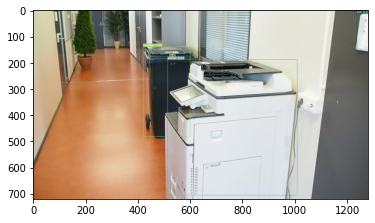

In [31]:
# Prediction
prediction_image_path = os.path.join('runs/detect/indoor_yolo_det/', image_name)
prediction_image = Image.open(prediction_image_path)
plt.imshow(np.array(prediction_image))

Comparing the 2 previous images we can verify that the Yolo v7 model detects a trashbin while in the original image, there is no label for it.

# Step 7: Future Work

Several steps can be taken to improve indoor object detection performance such as:


*   try training a bigger model architecture (yolov5m, yolov5l, ...)
*   explore different data augmentation
*   split the dataset by sequence
*   train a different object detection model (FasterRVNN, RetinaNet,...) 


